###  Q-learning and Reinforcement learning, FrozenLake- slippery grid

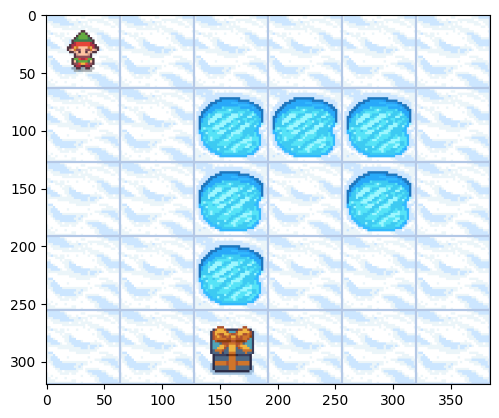

In [11]:
# importing the module libraries
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# define a custom map, S => start, G => goal, F => normal ice tile, H => hole 
custom_map = ["SFFFFF",
              "FFHHHF",
              "FFHFHF",
              "FFHFFF",
              "FFGFFF"]


# create the FrozenLake environment, ENABLE SLIPPERY
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array", desc=custom_map)

# it would be logical to have width + height
# we have to double-check that we get the correct values in this order 
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())

### Using Q-learning and RL to allow the Agent to move around

In [12]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

Observation space:
Discrete(30)

Action space:
Discrete(4)


In [13]:
# this is the table that is used in Q-learning
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(30, 4)

Q-Learning formula

Q(s,a) = Q(s, a) + alpha * (r + y * max(Q(s',a')) - Q(s, a))

In [14]:
# created the function that update the Q-Learning
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

### Creating a helper function for visualization of Q-values in the grid

In [15]:
#  An helper function is created to visualize the highest Q-values in the grid
def summarize_best_values(q_table, grid_width, grid_height):

    best_values = np.max(q_table, axis=1)

     # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_width, grid_height)

In [16]:
# helper variables for our Q-learning training algorithm
# episode => how many times the AI tries to play the game as it learns
total_episodes = 20000

# how many steps our agent tries within one episode
# until we give up with that episode
max_steps = 100

# learning rate (alpha): its ideal it starts from 0.5, 
learning_rate = 0.5

# this is how much the AI values long-term rewards over short-term rewards
# gamma of 0.9 is very typical in basic Q-learning 
gamma = 0.9

# epsilon does helps to
# determine how much our agent relies on current knowledge
# and how much the agent does wild guessing while training

# in the beginning of training 
# lots of guessing (high epsilon)
# but towards the end of training 
# then resulted to less guessing and more trusting previous knowledge (smaller epsilon)
# Simply because there is need for guessing in the beginning 
# whichhelps to start the learning
# know the optimal first steps in our current Q-table
epsilon = 0.9

# upper bound of our epsilon
max_epsilon = 0.9

# this is the lower bound, and our code is not going to decay the epsilon below this
min_epsilon = 0.01
decay_rate = 0.0005

### Now, training the agent with a for-loop (based on episodes)

### Also, due to complexity of the grids its ideal to fine tuned the policy

In [17]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # this get the initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

    
        # here, using the epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        # epsilon -> should we EXPLOIT our current knowledge or explore (wild guess)
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # the random action
            action = env.action_space.sample()


        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        
        # this will eventually guide the agent to choose the shortest path with least moves
        reward = reward - 0.01

       
        # if agent drops into a hole, we just adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break
            
        # updating the Q-table with the values we have right now
        # NOTE: this phase will be skipped if the agent dropped down a hole in previous section
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # ave current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # this checks for either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            #     print(f"Current Q-table - Episode: {episode}")
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # only print the result if our rewards are positive
    if total_rewards >= 0:
        print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

Steps taken: 48
Episode 4 done with total rewards: 0.5099999999999998, epsilon: 0.8982217788139265
Steps taken: 45
Episode 11 done with total rewards: 0.5399999999999998, epsilon: 0.895118436604938
Steps taken: 17
Episode 22 done with total rewards: 0.82, epsilon: 0.8902636481100782
Steps taken: 43
Episode 26 done with total rewards: 0.5599999999999998, epsilon: 0.888504880168056
Steps taken: 22
Episode 48 done with total rewards: 0.7699999999999999, epsilon: 0.8788942816845393
Steps taken: 10
Episode 49 done with total rewards: 0.89, epsilon: 0.8784599431373825
Steps taken: 9
Episode 76 done with total rewards: 0.9, epsilon: 0.8668145173931676
Steps taken: 11
Episode 94 done with total rewards: 0.88, epsilon: 0.8591377838554303
Steps taken: 16
Episode 106 done with total rewards: 0.83, epsilon: 0.8540582111092454
Steps taken: 14
Episode 114 done with total rewards: 0.85, epsilon: 0.8506887217362058
Steps taken: 9
Episode 135 done with total rewards: 0.9, epsilon: 0.8419076713482645
St

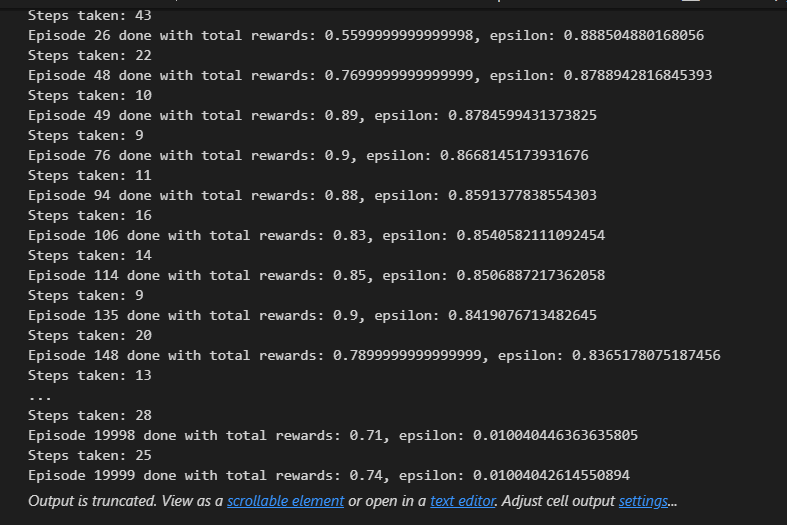

### Although, the epsilon reduced to the set minimum value 0.01 and the total reward increases from negative to positive values which shown the agent model was learning pretty well at beginning and also like flunctuating during the training i.e 0.89, 0.9, 0.88, 0.9 and then reduced to 0.74 at the end of the training process. 


In [18]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up

array([[ 1.67367425e-01,  2.02747415e-02, -3.69032474e-02,
        -3.69725794e-02],
       [ 8.53272578e-02, -4.62854720e-02, -5.30899440e-02,
        -4.67142371e-02],
       [-1.58921889e-01, -2.63661146e-01, -4.08990713e-01,
        -5.63629348e-02],
       [-2.53850006e-01, -2.13861757e-01, -3.08786560e-01,
        -7.12279466e-02],
       [-3.79852319e-01, -1.05274719e-01, -1.41106982e-01,
        -7.72035990e-02],
       [-7.71229184e-02, -7.72724778e-02, -7.77009390e-02,
        -7.76468682e-02],
       [ 4.85209751e-02,  1.80170026e-01,  1.51919037e-02,
        -2.74895893e-02],
       [ 1.27931926e-01, -5.30605645e-01, -4.68826489e-02,
        -2.19176313e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.35005379e-01, -5.28654547e-01, -7.24810022e-02,
      

In [19]:
# a helper function is needed for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

,0,1,2,3,4
0,0.167367,0.085327,-0.056363,-0.071228,-0.077204
1,-0.077123,0.180170,0.127932,0.000000,0.000000
2,0.000000,-0.072481,0.259434,0.155929,0.000000
3,-0.937500,0.000000,-0.058865,0.429573,0.615817
4,0.000000,-0.729381,0.098630,0.094160,0.504033
5,0.820174,0.000000,0.831038,0.631446,0.367234


### Each value in a list is the quality of action based on and as it increases so the agent learnt to follow the increased value pattern that get it to the reward (G). As the negative values the least action movement by the agent.

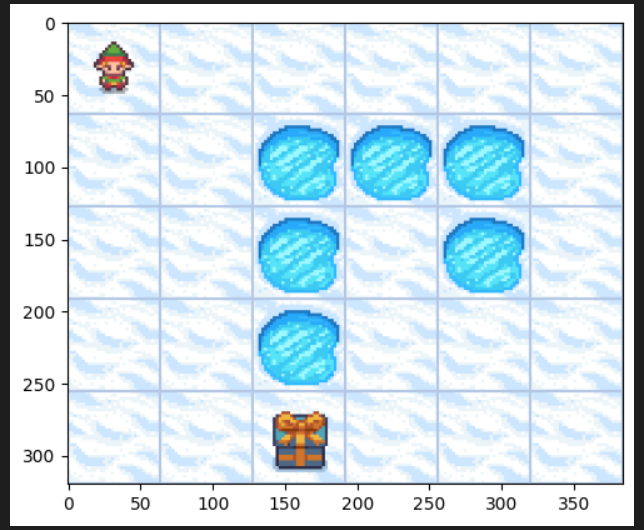

### Now playing the training game (Agent)

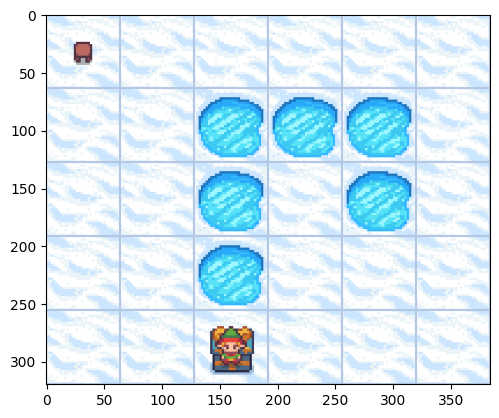

Episode: 5 done with total_rewards: 1.0


In [20]:
env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(0.3)

### I think increasing the number of total_episodes likely influenced the agent to learn pretty fast which enhance its action movement towards the reward/ Goal (G). As the epsilon became lower in value hence build more confidence to trust and thereby learn the implication of getting penalized if slipped and falls into the holes.